# 訓練 GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypianoroll
import pygame
import os
from mido import MidiFile
import wave
import pylab as pl
import glob
from pydub import AudioSegment
from pydub.utils import make_chunks
import tensorflow as tf
import pandas as pd

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/andrew/.local/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## 讀取鋼琴音樂檔，並以每10毫秒做切割，總共生成37200個訓練資料

In [2]:
# myaudio = AudioSegment.from_file("canon/canon in d CRD mastered.wav" , "wav") 
# chunk_length_ms = 10 # 分块的毫秒数
# chunks = make_chunks(myaudio, chunk_length_ms) #将文件切割成1秒每块
 
# #保存切割的音频到文件
 
# for i, chunk in enumerate(chunks):
#     chunk_name = "chunk{0}.wav".format(i)
#     print "exporting", chunk_name
#     chunk.export(str(canon)+'/'+chunk_name, format="wav")

In [3]:
wave_data = []
for data in glob.glob('canon/*ch*.wav'):
    f = wave.open(data, "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    str_data = f.readframes(nframes)
    f.close()
    wavedata = np.fromstring(str_data, dtype=np.short)
    wavedata.shape = -1, 2
    wavedata = wavedata.T
    wave_data.append(wavedata[0])
    wave_data.append(wavedata[1])

/home/andrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


(37200, 441)


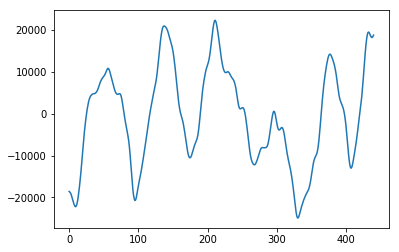

In [4]:
wave_data = np.array(wave_data)
print(wave_data.shape)
plt.plot(wave_data[0])

## 建立GAN模型

In [5]:
import keras
from keras.layers import Dense, Dropout, Input,BatchNormalization,Conv1D,Activation,Reshape,Flatten
from keras.layers import LeakyReLU
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

## 建立生成器

In [7]:
def get_generative(G_in, dense_dim=200, out_dim=441, lr=1e-4):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
#     opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer='adam')
    return G, G_out
G_in = Input(shape=[50])
G, G_out = get_generative(G_in)
G.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 441)               88641     
Total params: 98,841
Trainable params: 98,841
Non-trainable params: 0
_________________________________________________________________


## 建立鑑別器

In [13]:
def get_discriminative(D_in, lr=2e-4, drate=.25, n_channels=32, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(16, conv_sz, activation='relu')(x)
    x = LeakyReLU(0.2)(x)
#     x = Dropout(drate)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = LeakyReLU(0.2)(x)
#     x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_channels,activation='relu')(x)
    x = Dropout(0.5)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
#     dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer='adam')
    return D, D_out

D_in = Input(shape=[441])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 441)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 441, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 437, 16)           96        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 437, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 435, 64)           3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 435, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 27840)             0         
__________

## 建立GAN和鎖定訓練因子

In [14]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out
GAN_in = Input([50])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50)                0         
_________________________________________________________________
model_1 (Model)              (None, 441)               98841     
_________________________________________________________________
model_5 (Model)              (None, 2)                 895266    
Total params: 994,107
Trainable params: 98,841
Non-trainable params: 895,266
_________________________________________________________________


## 結合生成器的輸出以及輸入的資料，並給定label

In [15]:
def sample_data_and_gen(G, noise_dim=50, n_samples=37200):
    XT = wave_data[:n_samples]
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
#     print(XN_noise.shape)
    XN = G.predict(XN_noise)
#     print(XN.shape)
#     plt.plot(XN)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1 #給予label，前面n_samples為真實資料，label為1
    y[n_samples:, 0] = 1 #給予label，後面n_samples為假資料，label為0
#     print(X.shape,y.shape)
    return X, y


## 先拿取一部份資料做前端訓練，也可以全部資料都做訓練，隨著迭代次數增加，訓練效果越好。

In [16]:
def pretrain(G, D, noise_dim=50, n_samples=10000, batch_size=128):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=50, batch_size=batch_size)

pretrain(G, D)

Epoch 1/50
20000/20000 [==============================] - 8s 407us/step - loss: 2.7487
Epoch 2/50
20000/20000 [==============================] - 8s 382us/step - loss: 1.5139
Epoch 3/50
20000/20000 [==============================] - 8s 415us/step - loss: 1.0793
Epoch 4/50
20000/20000 [==============================] - 10s 483us/step - loss: 0.9331
Epoch 5/50
20000/20000 [==============================] - 10s 479us/step - loss: 0.8490
Epoch 6/50
20000/20000 [==============================] - 9s 470us/step - loss: 0.7396 
Epoch 7/50
20000/20000 [==============================] - 10s 508us/step - loss: 0.5415
Epoch 8/50
20000/20000 [==============================] - 9s 455us/step - loss: 0.3774
Epoch 9/50
20000/20000 [==============================] - 9s 469us/step - loss: 0.3713
Epoch 10/50
20000/20000 [==============================] - 9s 469us/step - loss: 0.3283
Epoch 11/50
20000/20000 [==============================] - 10s 517us/step - loss: 0.3307
Epoch 12/50
20000/20000 [===========

## 建立噪訊的長相，並開始訓練

In [17]:
def sample_noise(G, noise_dim=50, n_samples=1000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=50, n_samples=1000, noise_dim=50, batch_size=16, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

100%|██████████| 50/50 [00:50<00:00,  1.12it/s]

Epoch #50: Generative Loss: 15.095433235168457, Discriminative Loss: 0.11397026479244232


## 繪製損失函數圖

Text(0, 0.5, 'Loss')

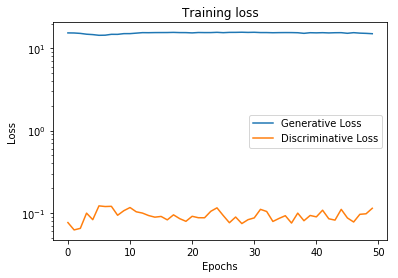

In [18]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

## 先顯示其中10筆，生成器所形成的資料。上方的圖為生成器產生，下方的圖為輸入的原始資料

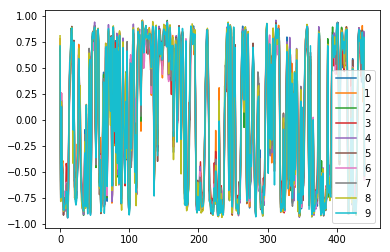

<Figure size 432x288 with 0 Axes>

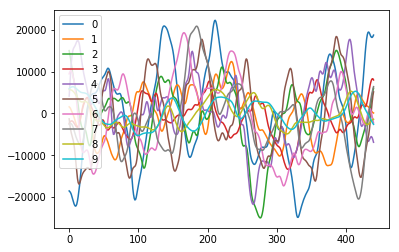

In [59]:
N_VIEWED_SAMPLES = 10
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()#顯示genrator生成的圖片
plt.figure()
pd.DataFrame(np.transpose(data_and_gen[:N_VIEWED_SAMPLES])).plot()

## 繪製一次的波形，結果發現完全無相似之處

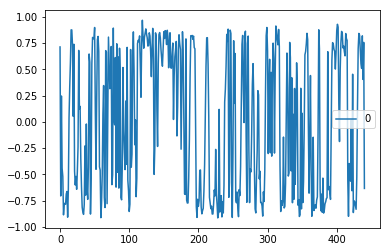

<Figure size 432x288 with 0 Axes>

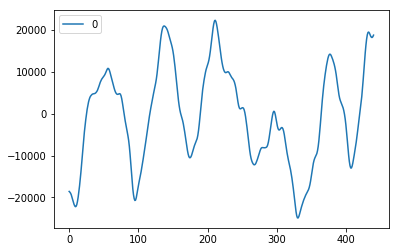

In [80]:
N_VIEWED_SAMPLES = 10
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES])).plot()#顯示genrator生成的圖片
plt.figure()
pd.DataFrame(np.transpose(data_and_gen[0])).plot()

## Smoothing

<Figure size 432x288 with 0 Axes>

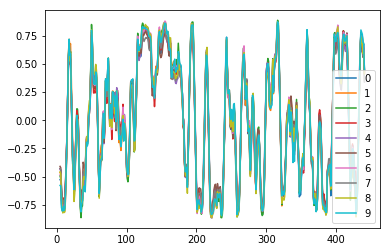

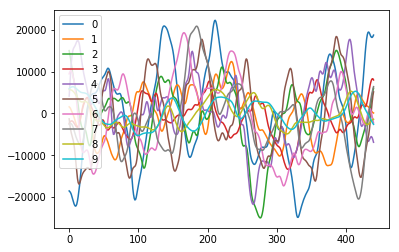

In [60]:
# N_VIEWED_SAMPLES = 10
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
plt.figure()
# plt.subplot(2,1,1)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()
# plt.subplot(2,1,2)
pd.DataFrame(np.transpose(data_and_gen[:N_VIEWED_SAMPLES])).plot()

## 我可以發現 Generator學習了原始音樂的外包絡線

## FFT分析，判斷Genrator所學習到的特徵與週期，並嘗試分析。

In [61]:
import math
from scipy.fftpack import fft

In [62]:
Realmusic=fft(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)]))
fftRealreal = Realmusic.real 
fftRealimag = Realmusic.imag

yfReal=abs(fft(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)])))                
yf1Real=abs(fft(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)])/len(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)]))))
yf2Real = yf1Real[range(int(len(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)])/2)))]

xfReal = np.arange(len(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)])))
xf1Real = xfReal
xf2Real = xfReal[range(int(len(np.transpose(data_and_gen[int(N_VIEWED_SAMPLES/2)])/2)))]

In [77]:
Fakemusic=fft(np.transpose(data_and_gen[6]))
fftFakereal = Fakemusic.real 
fftFakeimag = Fakemusic.imag

yfFake=abs(fft(np.transpose(data_and_gen[6])))                
yf1Fake=abs(fft(np.transpose(data_and_gen[6])/len(np.transpose(data_and_gen[6]))))
yf2Fake= yf1Fake[range(int(len(np.transpose(data_and_gen[6])/2)))]

xfFake = np.arange(len(np.transpose(data_and_gen[6])))
xf1Fake = xfFake
xf2Fake = xfFake[range(int(len(np.transpose(data_and_gen[6])/2)))]

## 原始資料的頻譜圖

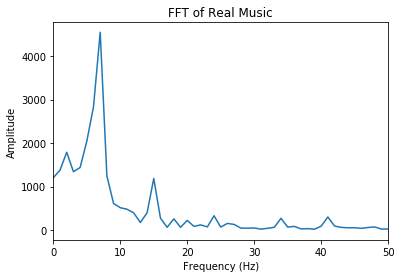

In [78]:
plt.figure()
plt.title('FFT of Real Music')
plt.xlim(0,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(xf2Real[:int(len(xf2Real)/2)],yf2Real[:int(len(yf2Real)/2)])

## 生成器產出的頻譜圖

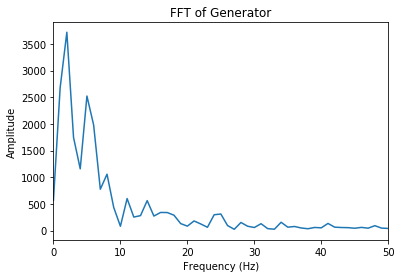

In [79]:
plt.figure()
plt.title('FFT of Generator')
plt.xlim(0,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(xf2Fake[:int(len(xf2Fake)/2)],yf2Fake[:int(len(yf2Fake)/2)])

## 雖然主頻的位置不一樣，但是在有頻率峰值的部份，Generator也有峰值出現 